## Setup and Installation

In [1]:
# Install required packages
!pip install accelerate==0.28.0 torch transformers datasets peft scikit-learn numpy pandas matplotlib --quiet

## Imports and Device Configuration

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re

from torch.utils.data import DataLoader
from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from peft import get_peft_model, LoraConfig, TaskType

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Text Cleaning & Preprocessing

In [3]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"\(.*?(AP|Reuters|AFP|Nasdaq).*?\)", "", text)
    text = re.sub(r"\([^)]*\)", "", text)
    text = re.sub(r"\[[^\]]*\]", "", text)
    text = re.sub(r"#\d+;", "", text)
    text = re.sub(r"[^A-Za-z0-9.,!?;:'\" \n]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


## Token Length Distribution

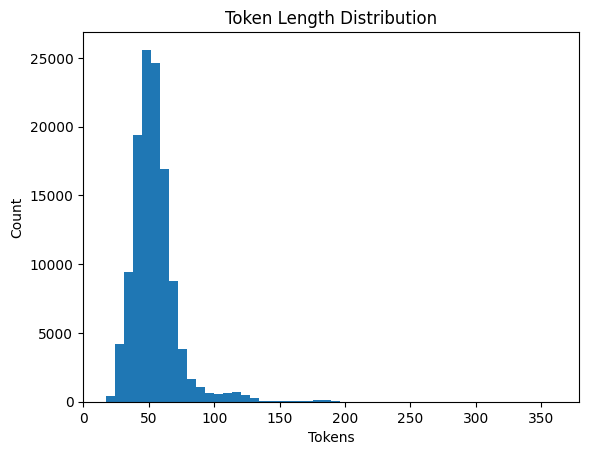

In [6]:
lengths = [len(tokenizer(x["text"])["input_ids"]) for x in dataset["train"]]
plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.show()


## Load and Prepare Dataset

In [7]:
dataset = load_dataset("ag_news")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

MIN_LEN = 10
MAX_LEN = 150

def is_clean(example):
    token_ids = tokenizer(example["text"])["input_ids"]
    return MIN_LEN <= len(token_ids) <= MAX_LEN

clean_dataset = dataset.filter(is_clean)
clean_dataset = clean_dataset.map(lambda x: {"text": clean_text(x["text"])})

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = clean_dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


## Load Model with LoRA Adapters

In [8]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["query"],
    lora_dropout=0.2,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.to(device)
model.print_trainable_parameters()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 741,124 || all params: 125,389,832 || trainable%: 0.5910558999712193


## Training Setup

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


##  Accuracy Callback for Plotting

In [13]:
class AccuracyCallback(TrainerCallback):
    def __init__(self):
        self.val_accuracies = []
        self.train_losses = []
        self.val_losses = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            self.val_accuracies.append(metrics.get("eval_accuracy"))
            self.val_losses.append(metrics.get("eval_loss"))

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.train_losses.append(logs["loss"])


## Train the Model

In [14]:
acc_callback = AccuracyCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[acc_callback]
)

trainer.train()


/home/ag10706/.local/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.229500,0.223921,0.926636
2,0.215600,0.208834,0.931527
3,0.200000,0.203325,0.934435


TrainOutput(global_step=22404, training_loss=0.23052809983784547, metrics={'train_runtime': 1863.4908, 'train_samples_per_second': 192.342, 'train_steps_per_second': 12.023, 'total_flos': 2.378102691454157e+16, 'train_loss': 0.23052809983784547, 'epoch': 3.0})

## Plot Accuracy and Loss Curves

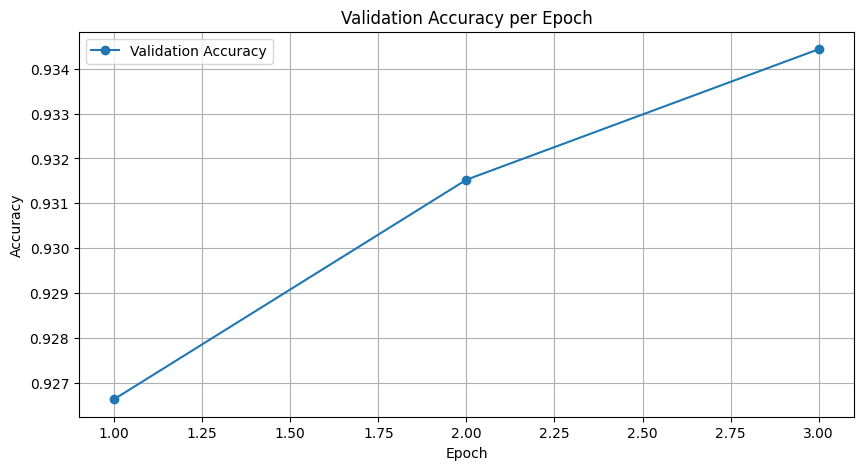

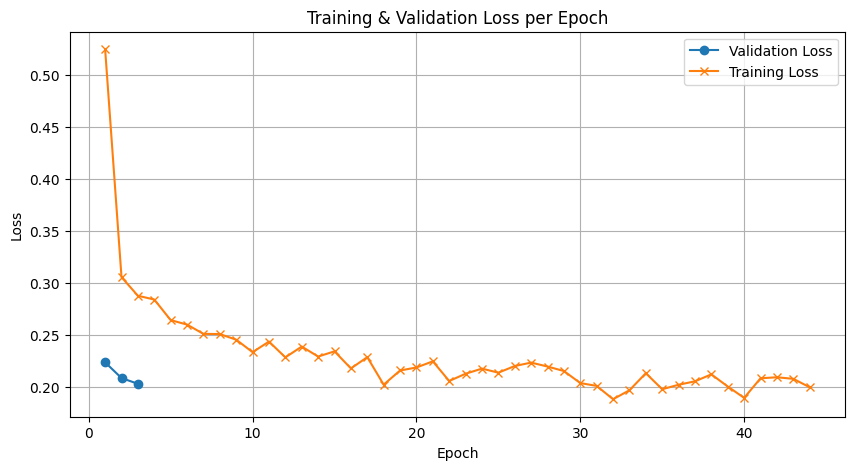

In [15]:
# Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(acc_callback.val_accuracies) + 1), acc_callback.val_accuracies, marker='o', label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Validation & Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(acc_callback.val_losses) + 1), acc_callback.val_losses, marker='o', label='Validation Loss')
plt.plot(range(1, len(acc_callback.train_losses) + 1), acc_callback.train_losses, marker='x', label='Training Loss')
plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


## Final Evaluation

In [16]:
eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])


Final Evaluation Accuracy: 0.9344348975545275


## Load, Tokenize and Predict on Test Data (Unlabeled)

In [21]:
from datasets import Dataset
from torch.utils.data import DataLoader

# Load dataset object
with open("test_unlabelled.pkl", "rb") as f:
    test_dataset = pickle.load(f)

# Convert to HuggingFace Dataset (already is, but this helps formatting)
test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

# Tokenize function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)


# also clean this data
# Apply cleaning
test_dataset = test_dataset.map(lambda x: {"text": clean_text(x["text"])})
# Apply tokenizer
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create PyTorch DataLoader for batching
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

# Prediction loop
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

## Save Submission File

In [20]:
df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),
    "label": all_predictions
})

submission_file = "submission-final.csv"
df.to_csv(submission_file, index=False)
print(f"Batched predictions complete. Saved to {submission_file}")


Batched predictions complete. Saved to submission-final.csv


## Error Analysis: Misclassifications

In [22]:
# Evaluate predictions on labeled test set
predictions = trainer.predict(tokenized_dataset["test"])
logits = predictions.predictions
probs = softmax(torch.tensor(logits), dim=-1)
preds = np.argmax(logits, axis=-1)
labels = predictions.label_ids

# Identify misclassified indices
misclassified_indices = np.where(preds != labels)[0]
raw_test_data = clean_dataset["test"]

errors = [{
    "text": raw_test_data[i]["text"],
    "true_label": labels[i],
    "predicted_label": preds[i],
    "confidence": float(probs[i][preds[i]])
} for i in misclassified_indices]

error_df = pd.DataFrame(errors).sort_values(by="confidence", ascending=False)
print("\nTop 10 confident misclassifications:\n")
print(error_df.head(10))
error_df.to_csv("high_confidence_misclassifications.csv", index=False)


TypeError: Wrong key type: '20' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.

## Misclassification Statistics per Label

In [ ]:
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Count total and misclassified per class
label_totals = pd.Series(labels).map(label_map).value_counts()
label_errors = pd.Series([labels[i] for i in misclassified_indices]).map(label_map).value_counts()
error_percentages = (label_errors / label_totals * 100).sort_values(ascending=False)

print("\nLabel-wise misclassification percentages:\n")
print(error_percentages)


## Confusion Matrix

In [ ]:
cm = confusion_matrix(labels, preds, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[i] for i in range(4)])
disp.plot(cmap="Blues", xticks_rotation=45, values_format=".2f")
plt.title("Normalized Confusion Matrix (Percentage per True Label)")
plt.grid(False)
plt.show()